In [312]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader, Subset
# import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [313]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

No GPU available!


In [724]:
df = pd.read_csv('./data/2011-2018_40*40include_well_网格划分.csv', dtype=float)

In [725]:
df

injection_vol_sum  injection_psi_sum  injection_depth_avg  \
0                   0.0                0.0                  0.0   
1                   0.0                0.0                  0.0   
2                   0.0                0.0                  0.0   
3                   0.0                0.0                  0.0   
4                   0.0                0.0                  0.0   
...                 ...                ...                  ...   
1595                0.0                0.0                  0.0   
1596                0.0                0.0                  0.0   
1597          1966271.0            33600.0               2251.0   
1598                0.0                0.0                  0.0   
1599           233380.0                0.0               1615.0   

      injection_under_basement_number  active_well_number  well_depth_avg  \
0                                 0.0                 6.0      508.333333   
1                                 0.0                 0.0        0.000000   
2                                 0.0                 3.0     1500.000000   
3                                 0.0                 1.0     1200.000000   
4                                 0.0                 5.0     1220.000000   
...                               ...                 ...             ...   
1595                              0.0               113.0     2194.495575   
1596                              0.0                88.0     1700.068182   
1597                              7.0                79.0     1850.848101   
1598                              0.0               151.0     1643.264901   
1599                              4.0                56.0     1387.321429   

      well_under_basement_number  depth_to_basement_avg  hf_number  \
0                            6.0              98.395007        0.0   
1                            0.0             124.268126        0.0   
2                            3.0             123.343495        0.0   
3                            1.0             126.236405        0.0   
4                            5.0             192.385935        0.0   
...                          ...                    ...        ...   
1595                       113.0               0.000000        0.0   
1596                        88.0               0.000000        0.0   
1597                        79.0               0.000000        0.0   
1598                       151.0               0.000000        0.0   
1599                        56.0               0.000000        0.0   

      hf_base_water_volume_sum  hf_base_nowater_volume_sum  \
0                          0.0                         0.0   
1                          0.0                         0.0   
2                          0.0                         0.0   
3                          0.0                         0.0   
4                          0.0                         0.0   
...                        ...                         ...   
1595                       0.0                         0.0   
1596                       0.0                         0.0   
1597                       0.0                         0.0   
1598                       0.0                         0.0   
1599                       0.0                         0.0   

      earthquake_occurence  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
1595                   0.0  
1596                   0.0  
1597                   0.0  
1598                   0.0  
1599                   0.0  

[1600 rows x 12 columns]

In [726]:
df.rename(columns = {"earthquake_occurence":"class"}, inplace=True)
df['class'].value_counts()

0.0    920
1.0    680
Name: class, dtype: int64

[Text(0, 0, '0'), Text(0, 0, '1')]

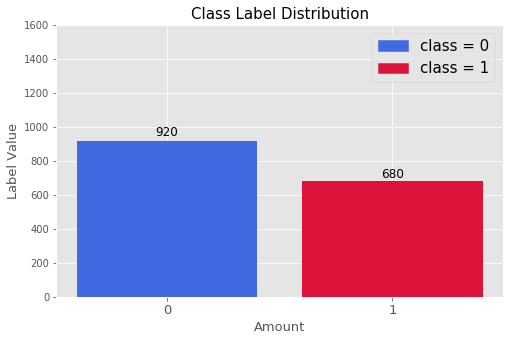

In [854]:
plt.style.use("ggplot")

x = ['0', '1']
y = df['class'].value_counts()

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x=x, height=y, color=['royalblue', 'crimson'])
ax.set_title("Class Label Distribution", fontsize=15)
ax.set_ylim(0,1600)

xticks = ax.get_xticks()
for i in range(len(y)):
    xy = (xticks[i], y[i] * 1.03)
    s = str(y[i])
    ax.annotate(
        s=s,  # 要添加的文本
        xy=xy,  # 将文本添加到哪个位置
        fontsize=12,  # 标签大小
        color="black",  # 标签颜色
        ha="center",  # 水平对齐
        va="baseline"  # 垂直对齐
    )
    
ax.set_xlabel("Amount", fontsize=13)
ax.set_ylabel("Label Value", fontsize=13)
    
red_patch = mpatches.Patch(color='crimson', label='class = 1')
blue_patch = mpatches.Patch(color='royalblue', label='class = 0')
ax.legend(handles=[blue_patch, red_patch], fontsize=15)
ax.set_xticklabels(labels=x, fontsize=13)

In [727]:
labels = df['class']

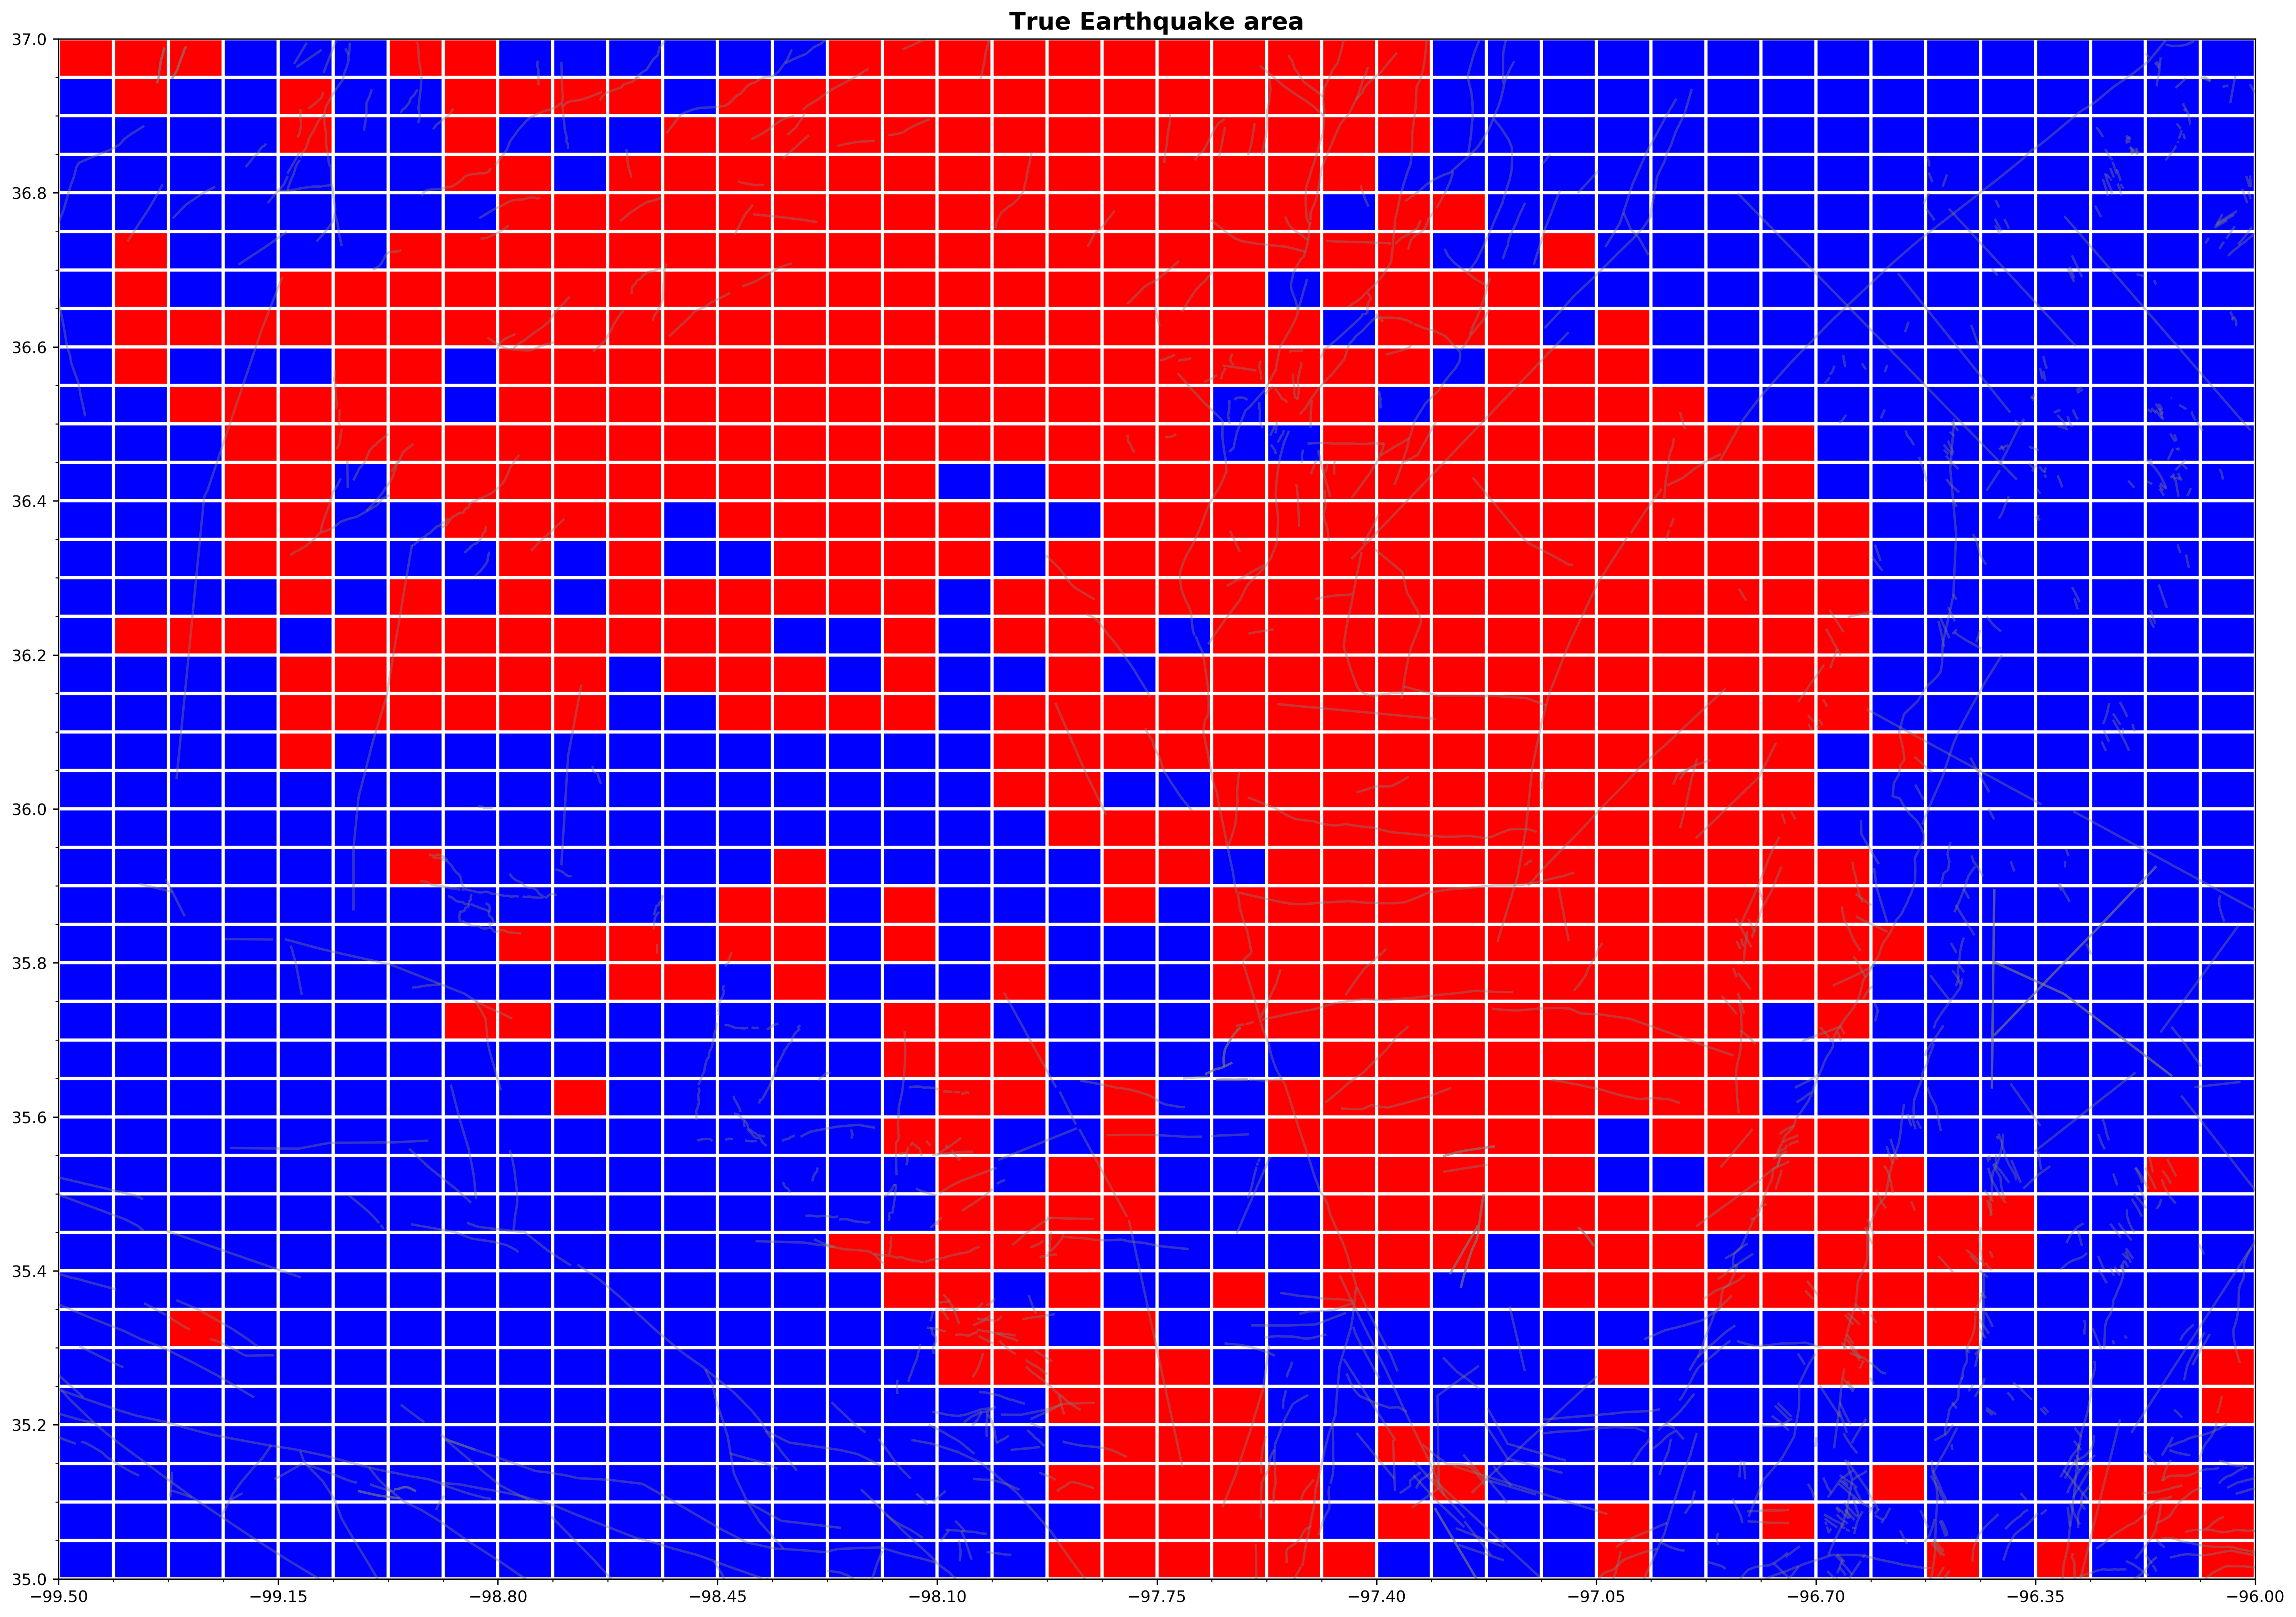

In [728]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1
# m, n = (41, 41)
x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

minor_x_ticks=np.linspace(-99.5,-96,m)
major_x_ticks=np.linspace(-99.5,-96,int((m-1)/4+1))
minor_y_ticks=np.linspace(35,37,n)
major_y_ticks=np.linspace(35,37,int((n-1)/4+1))
ax1.set_xticks(major_x_ticks)
ax1.set_yticks(major_y_ticks)
ax1.set_xticks(minor_x_ticks, minor=True)
ax1.set_yticks(minor_y_ticks, minor=True)
ax1.grid(color='w', linestyle='-', linewidth=2, which='major')
ax1.grid(color='w', linestyle='-', linewidth=2, which='minor')
    
ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')

# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.tight_layout()
plt.show()

# stepwise regression

In [729]:
## creating function to get model statistics
def get_stats():
    x = df[x_columns]
    y = df['class']
    
    mean_value = np.mean(x, axis=0)
    std_value = np.std(x, axis=0)

    feature_number = len(x_columns)
    # X_train
    for i in range(0, feature_number):
        feature_name = x_columns[i]
        x[feature_name]= (x[feature_name] - mean_value[feature_name]) / std_value[feature_name]

    results = sm.Logit(y, x).fit()
    print(results.summary())
    
def checkVIF_new(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    df['c'] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
    VIF = VIF[VIF.feature != 'c']
    max_VIF = max(VIF_list)
    print(VIF)

def remove_feature(feature):
    x_columns.remove(feature)
    if len(x_columns) > 0:
        get_stats()
        checkVIF_new(df[x_columns])

In [730]:
all_features = df.columns.tolist()[:-1]
all_features

['injection_vol_sum',
 'injection_psi_sum',
 'injection_depth_avg',
 'injection_under_basement_number',
 'active_well_number',
 'well_depth_avg',
 'well_under_basement_number',
 'depth_to_basement_avg',
 'hf_number',
 'hf_base_water_volume_sum',
 'hf_base_nowater_volume_sum']

In [731]:
x_columns = []
x_columns

[]

In [732]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_base_nowater_volume_sum
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1599
Method:                           MLE   Df Model:                            0
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                -0.01656
Time:                        19:35:19   Log-Likelihood:                -1109.0
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_nowater_volume_sum    

In [733]:
remove_feature('hf_base_nowater_volume_sum')

In [734]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_base_water_volume_sum
Optimization terminated successfully.
         Current function value: 0.687286
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1599
Method:                           MLE   Df Model:                            0
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:               -0.007966
Time:                        19:35:24   Log-Likelihood:                -1099.7
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum     0.2448 

In [735]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  hf_number
Optimization terminated successfully.
         Current function value: 0.660442
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1598
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.03140
Time:                        19:35:27   Log-Likelihood:                -1056.7
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.256e-16
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.5175      0.107     

In [736]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  depth_to_basement_avg
Optimization terminated successfully.
         Current function value: 0.637210
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1597
Method:                           MLE   Df Model:                            2
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.06548
Time:                        19:35:29   Log-Likelihood:                -1019.5
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.500e-32
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
hf_base_water_volume_sum    -0.4366    

In [737]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_under_basement_number
Optimization terminated successfully.
         Current function value: 0.634325
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1596
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.06971
Time:                        19:35:36   Log-Likelihood:                -1014.9
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.301e-33
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      

In [738]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  well_depth_avg
Optimization terminated successfully.
         Current function value: 0.619933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.09081
Time:                        19:35:58   Log-Likelihood:                -991.89
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.395e-42
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5690     

In [739]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  active_well_number
Optimization terminated successfully.
         Current function value: 0.619908
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.09085
Time:                        19:36:06   Log-Likelihood:                -991.85
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 6.791e-41
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5698 

In [740]:
remove_feature('active_well_number')

Optimization terminated successfully.
         Current function value: 0.619933
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.09081
Time:                        19:36:34   Log-Likelihood:                -991.89
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 9.395e-42
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
hf_base_water_volume_sum      -0.5690      0.111     -5.105      0.000      

In [741]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_under_basement_number
Optimization terminated successfully.
         Current function value: 0.616025
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.09655
Time:                        19:36:39   Log-Likelihood:                -985.64
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 1.489e-43
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_v

In [742]:
remove_feature('well_under_basement_number')

Optimization terminated successfully.
         Current function value: 0.616863
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                 0.09532
Time:                        19:36:44   Log-Likelihood:                -986.98
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 7.246e-44
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.6131      0.114     -5.368  

In [743]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_depth_avg
Optimization terminated successfully.
         Current function value: 0.593074
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                  0.1302
Time:                        19:36:56   Log-Likelihood:                -948.92
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.619e-59
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum   

In [744]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_psi_sum
Optimization terminated successfully.
         Current function value: 0.593073
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                  0.1302
Time:                        19:36:58   Log-Likelihood:                -948.92
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.081e-58
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum     

In [745]:
remove_feature('injection_psi_sum')

Optimization terminated successfully.
         Current function value: 0.593074
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                  0.1302
Time:                        19:37:04   Log-Likelihood:                -948.92
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 2.619e-59
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum           -0.5982      0.114     -5.249  

In [746]:
selected_feature = all_features[-1]
print('Feature selected: ', selected_feature)
x_columns.append(selected_feature)
all_features.remove(selected_feature)
get_stats()
checkVIF_new(df[x_columns])

Feature selected:  injection_vol_sum
Optimization terminated successfully.
         Current function value: 0.590683
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Aug 2021   Pseudo R-squ.:                  0.1337
Time:                        19:37:07   Log-Likelihood:                -945.09
converged:                       True   LL-Null:                       -1091.0
Covariance Type:            nonrobust   LLR p-value:                 4.787e-60
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
hf_base_water_volume_sum     

In [747]:
x_columns

['hf_base_water_volume_sum',
 'hf_number',
 'depth_to_basement_avg',
 'well_depth_avg',
 'injection_under_basement_number',
 'injection_depth_avg',
 'injection_vol_sum']

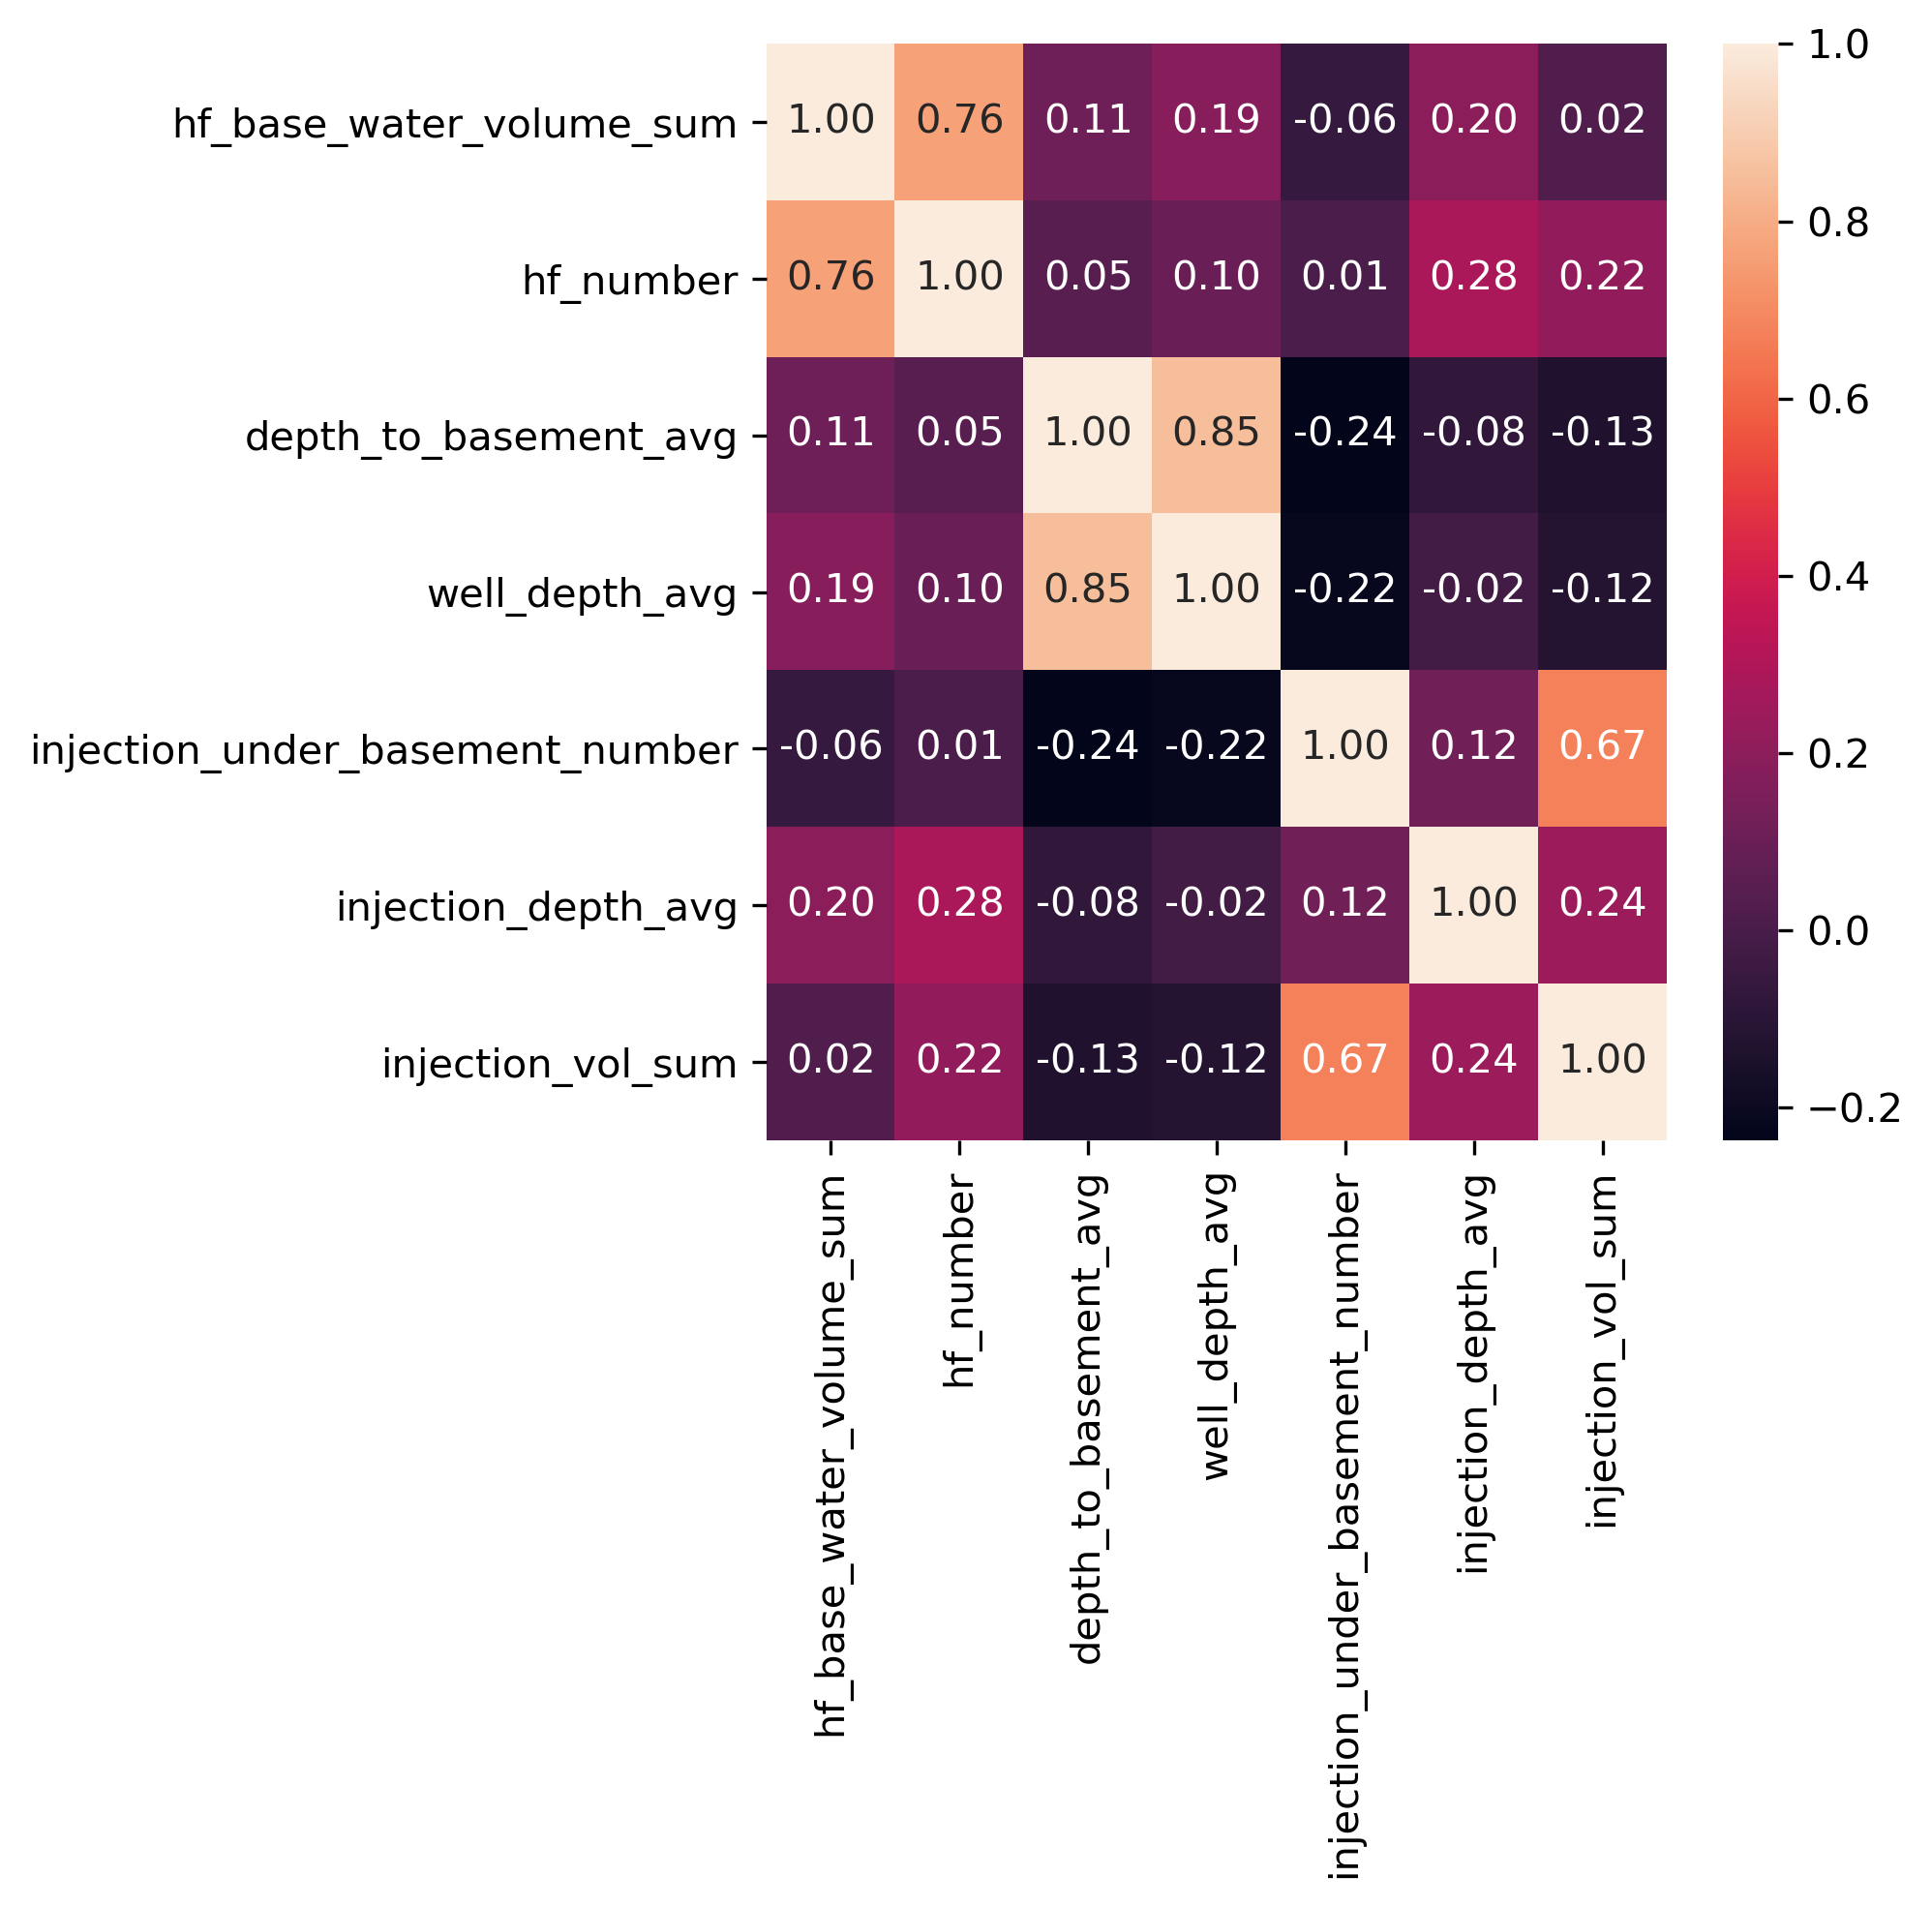

In [748]:
import seaborn as sns
# data=data_df
# # 相关性计算
dcorr = df[x_columns].corr()
plt.figure(figsize=(5, 5),dpi=300)
fig = sns.heatmap(data=dcorr, annot=True, fmt=".2f")

heat_fig = fig.get_figure()
heat_fig.savefig('./heatmap.png', dpi = 100)

In [749]:
#特征features
X = df[x_columns].values
#标签labels
Y = df['class'].values

X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8, random_state=42)

mean_value = np.mean(X_train, axis=0)
std_value = np.std(X_train, axis=0)

feature_number = len(x_columns)
# X_train
for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]

#输出数据大小
print('原始数据特征：',X.shape,
     '训练数据特征：',X_train.shape,
      '测试数据特征',X_test.shape)

print('原始数据标签：',Y.shape,
     '训练数据标签：',y_train.shape,
      '测试数据标签',y_test.shape)

feature_number = len(x_columns)

#将训练数据特征转换成二维数组X行*1列
X_train=X_train.reshape(-1,feature_number)
#将测试数据特征转换成二维数组X行*1列
X_test=X_test.reshape(-1,feature_number)


#第一步：创建模型：逻辑回归
LR_model=LogisticRegression()
#第二步：训练模型
LR_model.fit(X_train,y_train)

#第三步: 评估模型：准确率
LR_model.score(X_test,y_test)

原始数据特征： (1600, 7) 训练数据特征： (1280, 7) 测试数据特征 (320, 7)
原始数据标签： (1600,) 训练数据标签： (1280,) 测试数据标签 (320,)


0.721875

In [750]:
LR_model.coef_[0]

array([-0.44748878,  0.86071737, -1.63628814,  1.09045711, -0.6480896 ,
        0.45606104,  0.23666933])

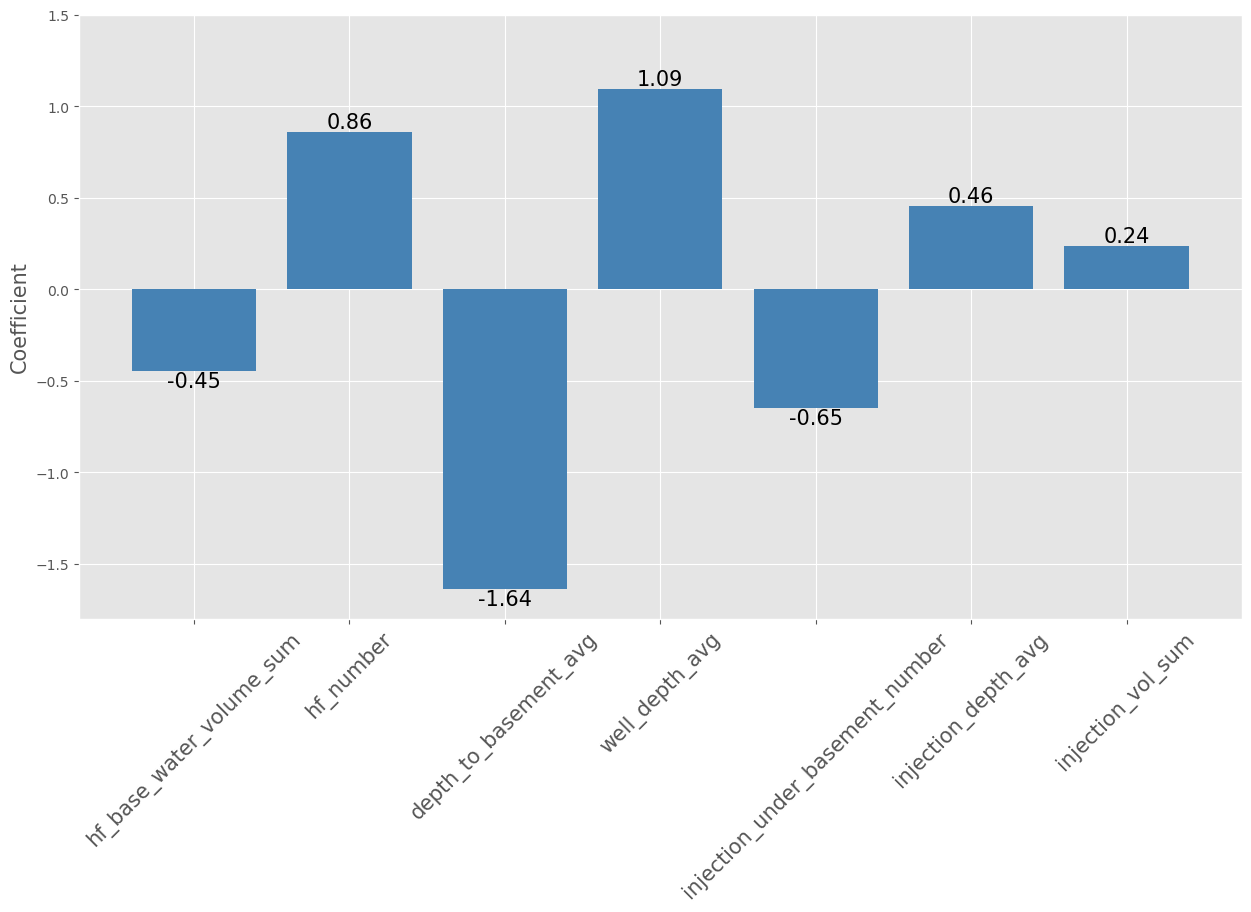

In [872]:
X = x_columns
Y = LR_model.coef_[0]
fig = plt.figure(figsize=(15, 8), dpi=100)
plt.bar(X,Y, color="steelblue")

for x,y in zip(X,Y):
    if y > 0:
        plt.text(x,y,'%.2f' %y, ha='center',va='bottom', fontsize=15)
    else:
        plt.text(x,y,'%.2f' %y, ha='center',va='top', fontsize=15)

# plt.xlabel("Feature", fontsize=15)
plt.ylabel("Coefficient", fontsize=15)
# plt.title("Coefficients in Model", fontsize=18)
plt.xticks(rotation=45, fontsize=15) # 倾斜70度
plt.ylim(-1.8, 1.5)
plt.show()

In [751]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [691]:
def confusion_matrix_(y_pred,y_true):
    '''
    params:
        y_pred:预测值
        y_true:真实值
    result:
        绘制混淆矩阵和准确率、精确率、F1值
    '''
    CM = confusion_matrix(y_true,y_pred)
    
    fig = plt.figure(figsize=(12,6))
    
    fig.suptitle(r'Confusion Matrix')
    #画热力图
    ax1 = fig.add_subplot(1,2,1)
    sns.heatmap(CM,annot=True,cmap='Blues',linewidths=0.5,ax=ax1)
    ax1.set_xlabel('predicate')
    ax1.set_ylabel('true')
    
    #文本显示指标
    
    (tn,fp,fn,tp) = CM.ravel()
    acc = accuracy_score(y_true, y_pred)
    pre0 = tn/(fn+tn); pre1 = tp/(tp+fp)
    recall0 = tn/(fp+tn); recall1 = tp/(tp+fn)
    f10 = 2*tn/(2*tn+fp+fn)
    f11 = 2*tp/(2*tp+fp+fn)
    col_labels = ['precision','recall','F1']
    row_labels = [' '*4+'0'+' '*4,' '*4+'1'+' '*4]
    table_vals = [[pre0,recall0,f10],[pre1,recall1,f11]]
    ax2 = fig.add_subplot(1,2,2)
    ax2.table(cellText=table_vals,rowLabels=row_labels,
              colLabels=col_labels,loc='center')
    ax2.text(0.35,0.6,
             r'''
            accuracy: {acc}
              '''.format(acc=acc),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=20, color='black',
        transform=ax2.transAxes)
    ax2.axis('off')
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.show()   

acc: 0.702
precision: 0.6883910386965377
recall: 0.3634408602150538
F1-score: 0.4757213230119634


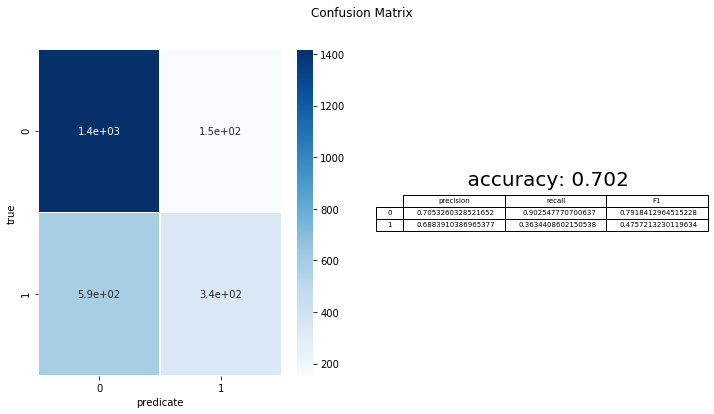

In [692]:
from sklearn.linear_model import LogisticRegression

test_labels = df['class'].values
test_features = df[x_columns].values

feature_number = len(x_columns)
for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]
    
out_classes = LR_model.predict(test_features)
print("acc:", accuracy_score(test_labels, out_classes))
print("precision:", precision_score(test_labels, out_classes))
print("recall:", recall_score(test_labels, out_classes))
print("F1-score:", f1_score(test_labels, out_classes))
confusion_matrix_(out_classes,test_labels)

<Figure size 432x288 with 0 Axes>

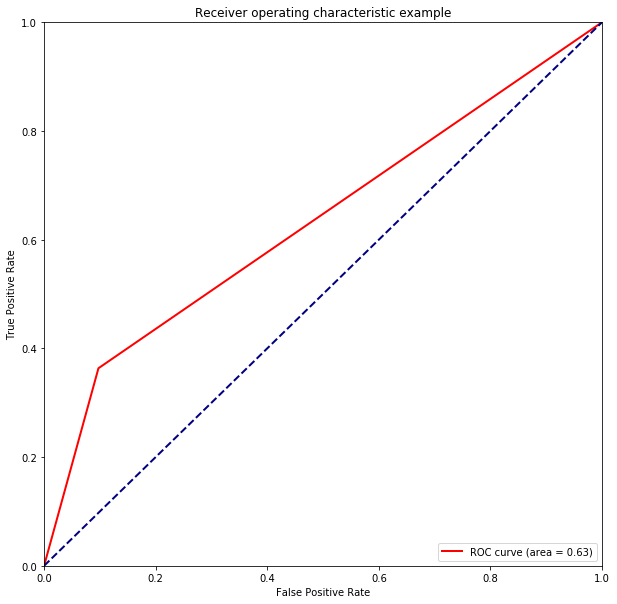

In [693]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(test_labels, out_classes) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

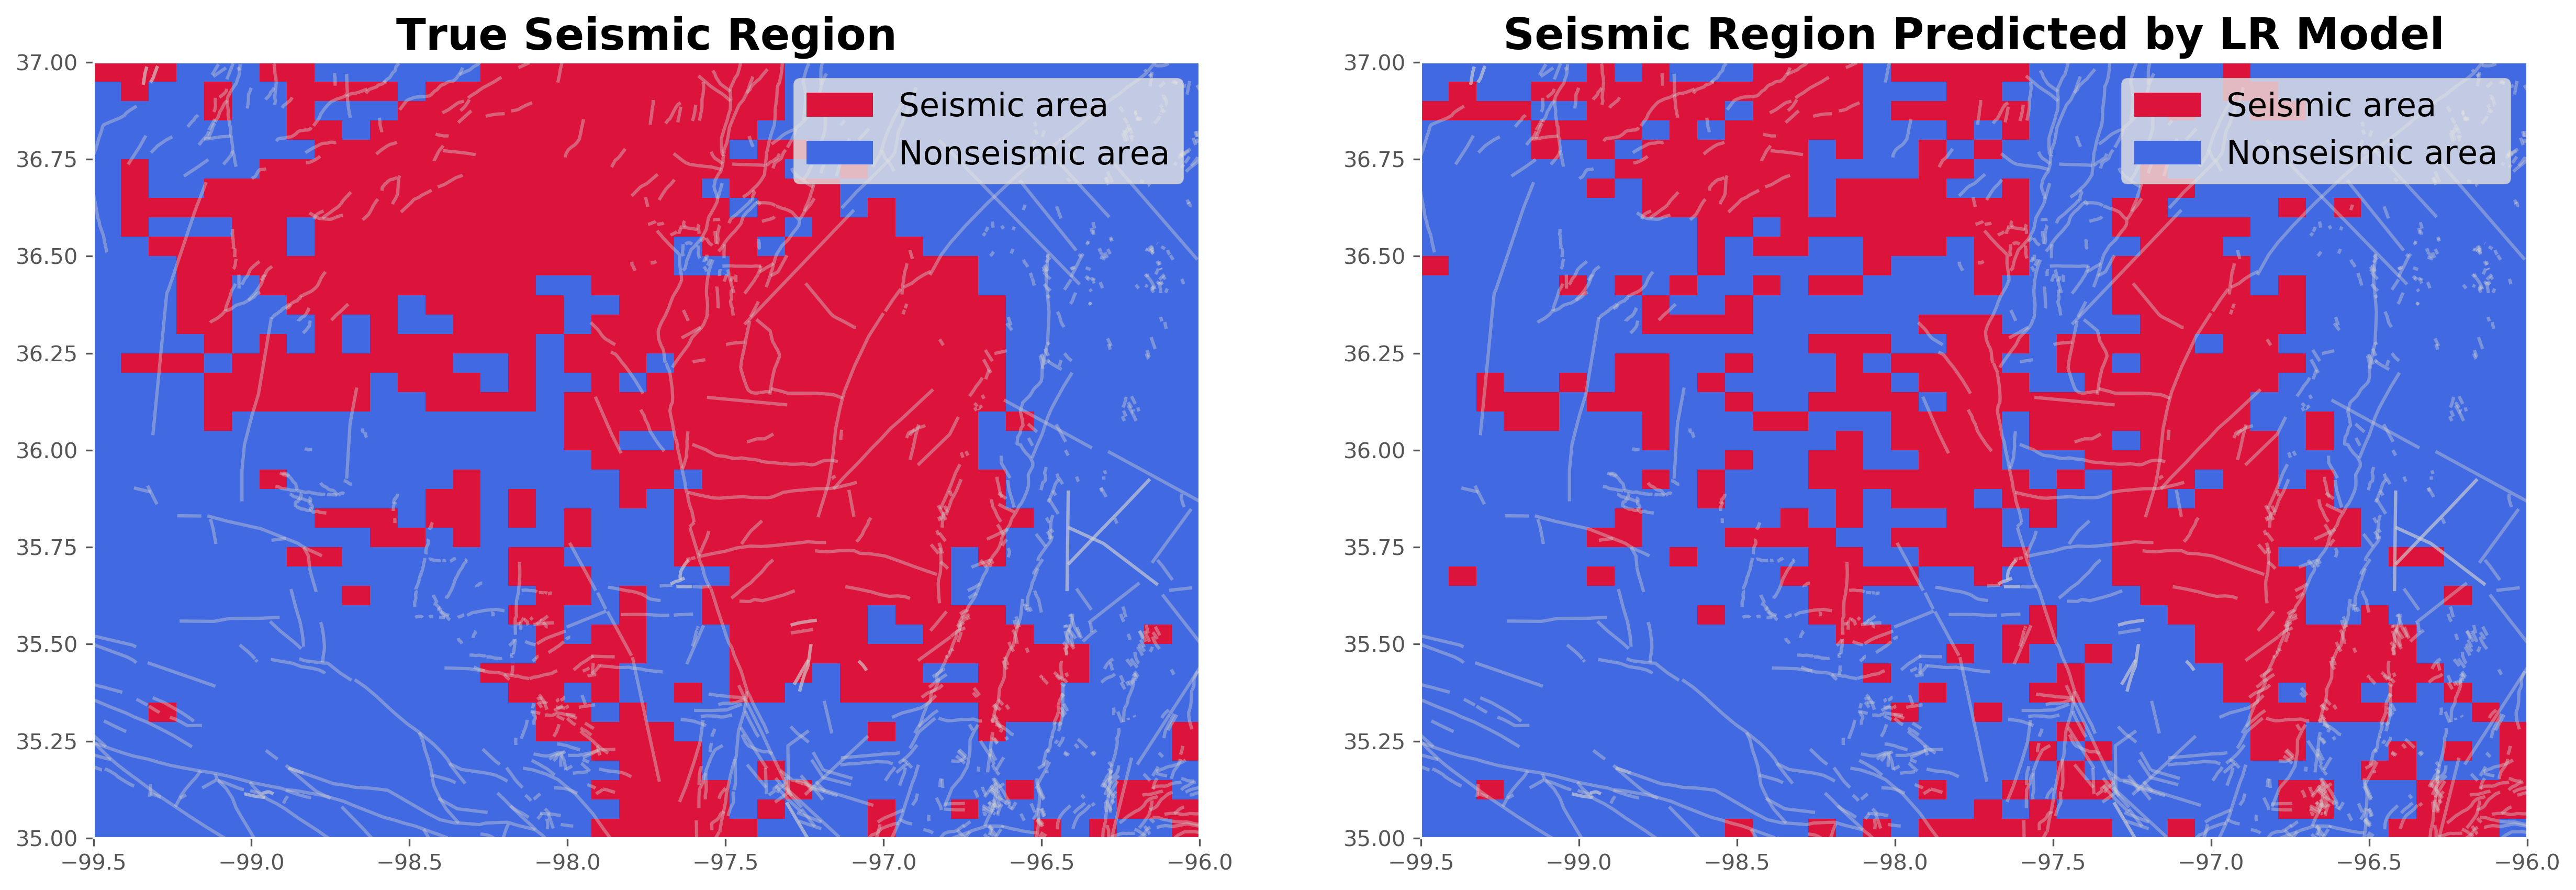

In [875]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='lightgrey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

plot_list = LR_out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax2.set_xlim(-99.5, -96)
ax2.set_ylim(35, 37)
ax1.set_title('True Seismic Region', fontsize=20,fontweight='bold')
ax2.set_title('Seismic Region Predicted by LR Model', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax1.legend(handles=[red_patch, blue_patch], fontsize=15)
ax2.legend(handles=[red_patch, blue_patch], fontsize=15)
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

# network construction

In [752]:
x_columns

['hf_base_water_volume_sum',
 'hf_number',
 'depth_to_basement_avg',
 'well_depth_avg',
 'injection_under_basement_number',
 'injection_depth_avg',
 'injection_vol_sum']

In [753]:
features = df[x_columns]
target = df['class']

In [754]:
feature_names = features.columns.tolist()
print(feature_names)

['hf_base_water_volume_sum', 'hf_number', 'depth_to_basement_avg', 'well_depth_avg', 'injection_under_basement_number', 'injection_depth_avg', 'injection_vol_sum']


In [755]:
# import matplotlib.pyplot as plt
# import seaborn as sns  # seaborn作为matplotlib的补充，导入后会覆盖matplotlib的默认作图风格

# sns.pairplot(df, hue='class', vars=feature_names)  # hue : 使用指定变量为分类变量画图；vars : 与data使用，否则使用data的全部变量
# plt.show()  # 仍然使用matplotlib的显示函数

In [756]:
features

hf_base_water_volume_sum  hf_number  depth_to_basement_avg  \
0                          0.0        0.0              98.395007   
1                          0.0        0.0             124.268126   
2                          0.0        0.0             123.343495   
3                          0.0        0.0             126.236405   
4                          0.0        0.0             192.385935   
...                        ...        ...                    ...   
1595                       0.0        0.0               0.000000   
1596                       0.0        0.0               0.000000   
1597                       0.0        0.0               0.000000   
1598                       0.0        0.0               0.000000   
1599                       0.0        0.0               0.000000   

      well_depth_avg  injection_under_basement_number  injection_depth_avg  \
0         508.333333                              0.0                  0.0   
1           0.000000                              0.0                  0.0   
2        1500.000000                              0.0                  0.0   
3        1200.000000                              0.0                  0.0   
4        1220.000000                              0.0                  0.0   
...              ...                              ...                  ...   
1595     2194.495575                              0.0                  0.0   
1596     1700.068182                              0.0                  0.0   
1597     1850.848101                              7.0               2251.0   
1598     1643.264901                              0.0                  0.0   
1599     1387.321429                              4.0               1615.0   

      injection_vol_sum  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
1595                0.0  
1596                0.0  
1597          1966271.0  
1598                0.0  
1599           233380.0  

[1600 rows x 7 columns]

In [757]:
class Net(nn.Module):
    def __init__(self,n_input, n_output):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_input, 8)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, n_output)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.linear3(sigmoid_out2)

In [758]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.float().to(device), y.long().to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, feature_number))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.float().to(device), y.long().to(device)
            a2 = model(X.view(-1, feature_number))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

# Train the model, validation and evaluation

In [762]:
# Define the hyperparameters
seed = 42
lr = 1e-2
# momentum = 0.8
batch_size = 16
test_batch_size = 16
n_epochs = 200

feature_number = len(feature_names)
NN_model = Net(feature_number,2)

In [763]:
Y = target.values
X = features.values
# data_tensor = TensorDataset(torch.tensor(X), torch.tensor(Y))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train = X[indices[0]]
X_test = X[indices[1]]
Y_train = Y[indices[0]]
Y_test = Y[indices[1]]

mean_value = np.mean(X[indices[0]], axis=0)
std_value = np.std(X[indices[0]], axis=0)


for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

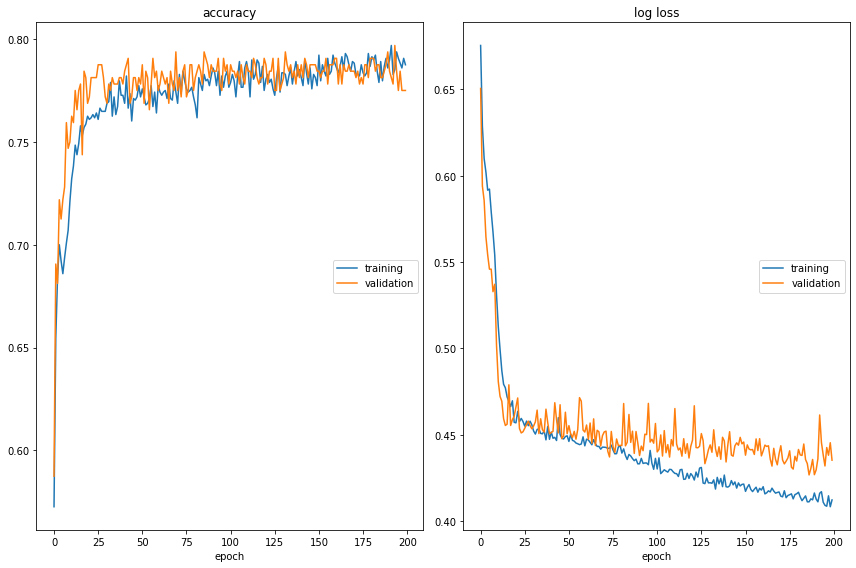

accuracy
	training         	 (min:    0.573, max:    0.797, cur:    0.787)
	validation       	 (min:    0.588, max:    0.797, cur:    0.775)
log loss
	training         	 (min:    0.408, max:    0.675, cur:    0.412)
	validation       	 (min:    0.427, max:    0.651, cur:    0.435)

Avg. Test Loss: 0.435  Avg. Test Accuracy: 0.775


In [764]:
set_seed(seed)
optimizer = torch.optim.Adam(NN_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(NN_model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(NN_model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()


test_loss, test_accuracy = validate(NN_model, criterion, test_loader)  
print("")
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

In [765]:
# 训练集拟合程度
NN_model.eval()
test_features = X_train
test_labels = Y_train
test_input_tensor = torch.from_numpy(test_features)
out_probs = NN_model(test_input_tensor.float()).detach()
out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.79375


# Feature Importance

In [511]:
from captum.attr import FeaturePermutation, IntegratedGradients

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(20,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xticks(rotation=15)
        plt.xlabel(axis_title, fontsize=15)
        plt.title(title)

Average Feature Importances
hf_base_water_volume_sum :  -0.363
hf_number :  -0.166
depth_to_basement_avg :  -0.305
well_depth_avg :  -0.479
injection_under_basement_number :  -0.040
injection_depth_avg :  0.093
injection_vol_sum :  -0.032


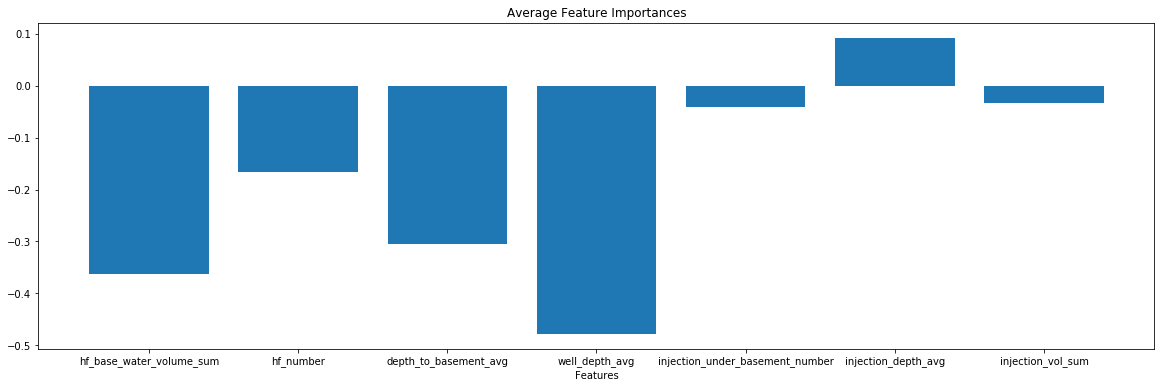

In [510]:
ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor.float(),target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
visualize_importances(feature_names, np.mean(attr, axis=0))

# Save the model

In [452]:
NN_model.parameters()
path = "./model/EarthquakePredict_2010-2018_40*40_80ac.pt"
torch.save(NN_model.state_dict,path)

# Test on all the dataset to reproduction

In [708]:
NN_model.eval()
test_features = X
test_labels = Y

for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]

test_input_tensor = torch.from_numpy(test_features)
out_probs = NN_model(test_input_tensor.float()).detach()
NN_out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("NN Test Accuracy:", sum(NN_out_classes == test_labels) / len(test_labels))

NN Test Accuracy: 0.628


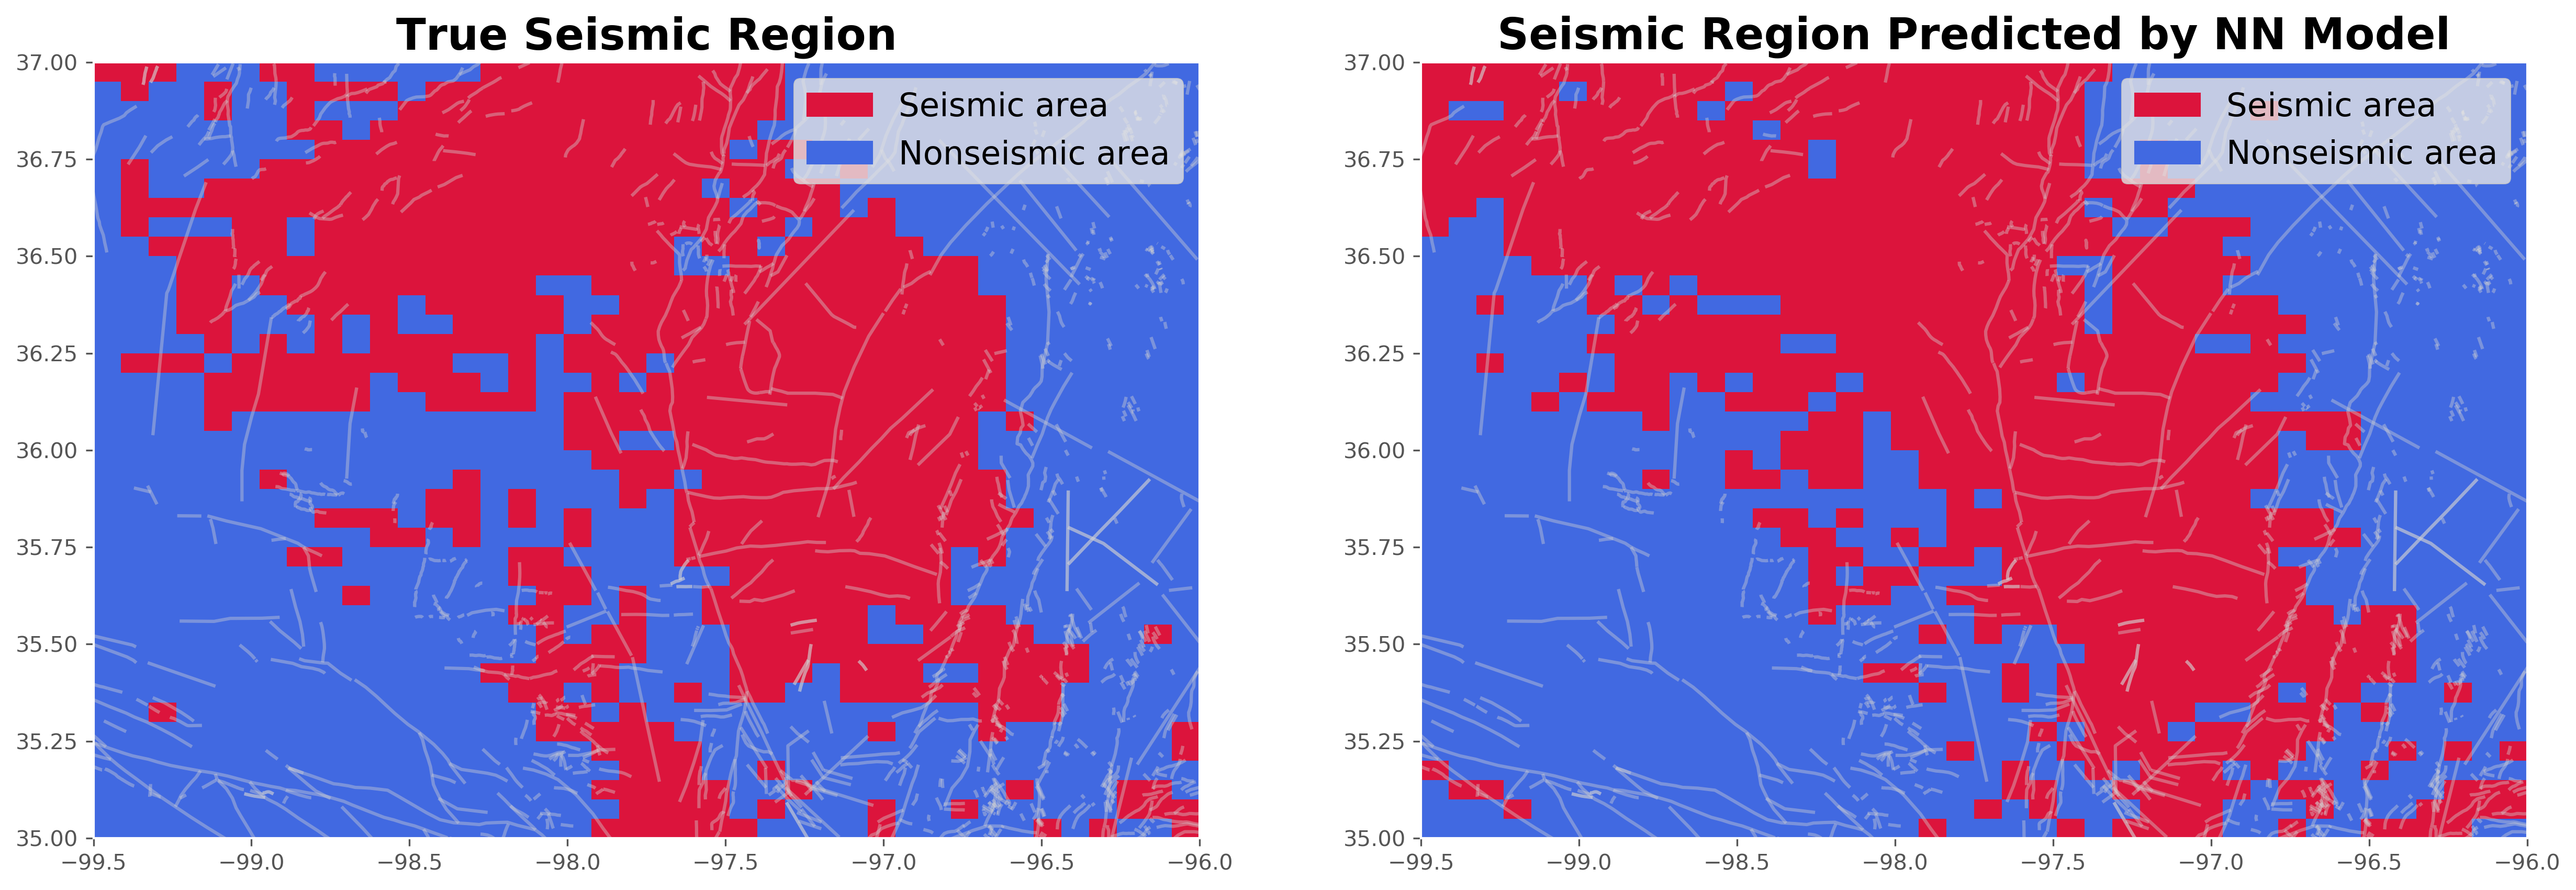

In [876]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='lightgrey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

plot_list = NN_out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax2.set_xlim(-99.5, -96)
ax2.set_ylim(35, 37)
ax1.set_title('True Seismic Region', fontsize=20,fontweight='bold')
ax2.set_title('Seismic Region Predicted by NN Model', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax1.legend(handles=[red_patch, blue_patch], fontsize=15)
ax2.legend(handles=[red_patch, blue_patch], fontsize=15)
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

In [766]:
NN_model.eval()

test_features = X
test_labels = Y

for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]

test_input_tensor = torch.from_numpy(test_features)

LR_out_classes = LR_model.predict(test_input_tensor)

out_probs = NN_model(test_input_tensor.float()).detach()
NN_out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()

In [768]:
NN_out_classes

array([0, 0, 0, ..., 0, 0, 0])

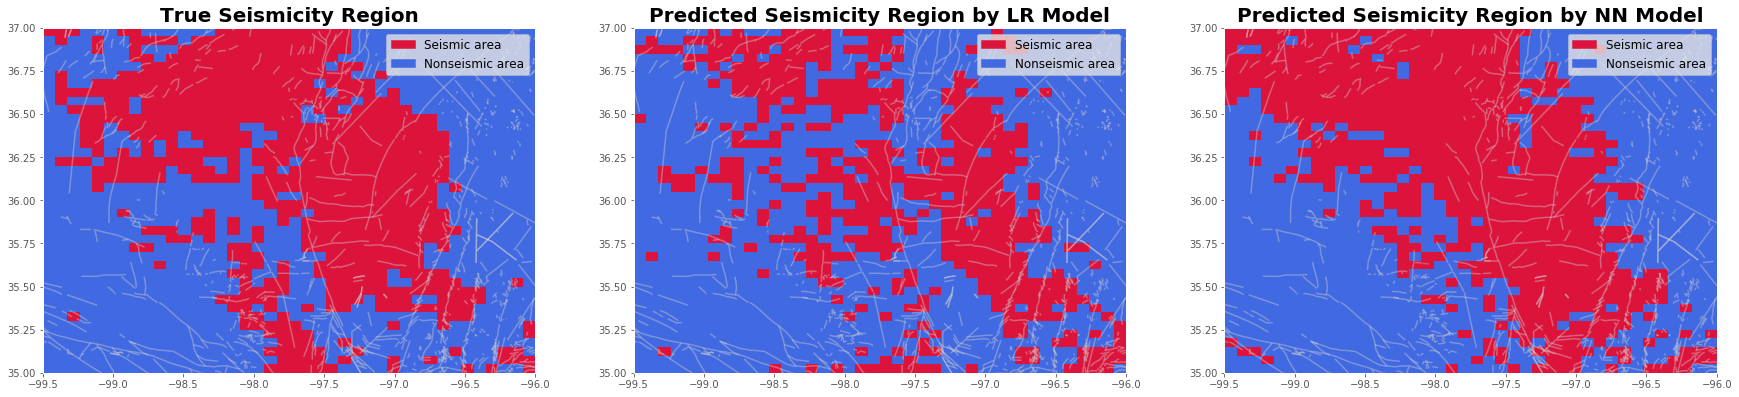

In [856]:
import matplotlib.patches as mpatches

m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

x = np.linspace(-99.5, -96, m)
y = np.linspace(35, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(30, 30))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='lightgrey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='lightgrey')
oklahoma_map.plot(ax=ax3, alpha=0.4,color='lightgrey')

# 设置地图范围
lat = np.linspace(35, 37, m) # y
lon = np.linspace(-99.5, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

plot_list = LR_out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1
        
plot_list = NN_out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax3.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='royalblue')
        else:
            ax3.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='crimson')
        i = i+1

ax1.set_xlim(-99.5, -96)
ax1.set_ylim(35, 37)
ax2.set_xlim(-99.5, -96)
ax2.set_ylim(35, 37)
ax3.set_xlim(-99.5, -96)
ax3.set_ylim(35, 37)
ax1.set_title('True Seismicity Region', fontsize=20,fontweight='bold')
ax2.set_title('Predicted Seismicity Region by LR Model', fontsize=20,fontweight='bold')
ax3.set_title('Predicted Seismicity Region by NN Model', fontsize=20,fontweight='bold')


red_patch = mpatches.Patch(color='crimson', label='Seismic area')
blue_patch = mpatches.Patch(color='royalblue', label='Nonseismic area')
ax1.legend(handles=[red_patch, blue_patch], fontsize=12)
ax2.legend(handles=[red_patch, blue_patch], fontsize=12)
ax3.legend(handles=[red_patch, blue_patch], fontsize=12)
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

acc: 0.705
precision: 0.7023346303501945
recall: 0.5308823529411765
F1-score: 0.6046901172529312


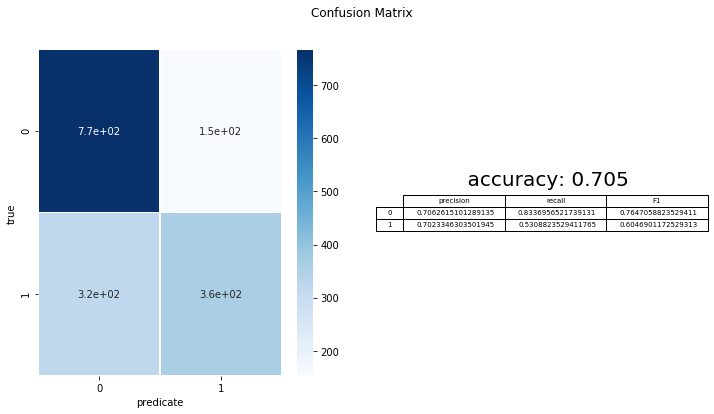

In [774]:
print("acc:", accuracy_score(test_labels, LR_out_classes))
print("precision:", precision_score(test_labels, LR_out_classes))
print("recall:", recall_score(test_labels, LR_out_classes))
print("F1-score:", f1_score(test_labels, LR_out_classes))
confusion_matrix_(LR_out_classes,test_labels)

acc: 0.79
precision: 0.7343324250681199
recall: 0.7926470588235294
F1-score: 0.7623762376237624


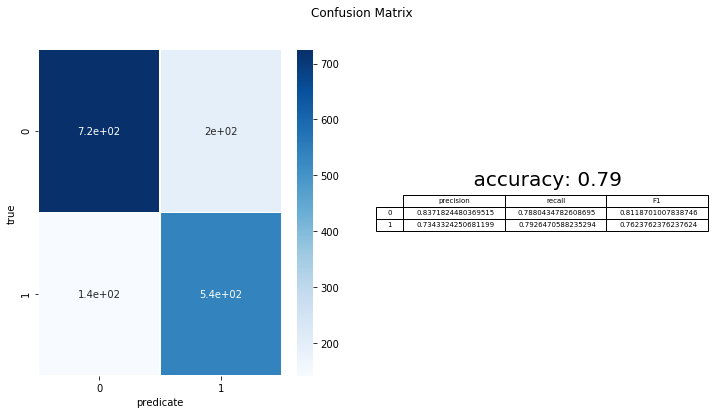

In [775]:
print("acc:", accuracy_score(test_labels, NN_out_classes))
print("precision:", precision_score(test_labels, NN_out_classes))
print("recall:", recall_score(test_labels, NN_out_classes))
print("F1-score:", f1_score(test_labels, NN_out_classes))
confusion_matrix_(NN_out_classes,test_labels)